#### Helpers

In [2]:
# Running covariance computation

import numpy as np
import torch
import re
from typing import Optional


class OnlineCovariance:
    """
    A class to calculate the mean and the covariance matrix
    of the incrementally added, n-dimensional data.
    """

    def __init__(self, order):
        """
        Parameters
        ----------
        order: int, The order (=="number of features") of the incrementally added
        dataset and of the resulting covariance matrix.
        """
        self._order = order
        self._shape = (order, order)
        self._identity = np.identity(order)
        self._ones = np.ones(order)
        self._count = 0
        self._mean = np.zeros(order)
        self._cov = np.zeros(self._shape)

    @property
    def count(self):
        """
        int, The number of observations that has been added
        to this instance of OnlineCovariance.
        """
        return self._count

    @property
    def mean(self):
        """
        double, The mean of the added data.
        """
        return self._mean

    @property
    def cov(self):
        """
        array_like, The covariance matrix of the added data.
        """
        return self._cov

    @property
    def corrcoef(self):
        """
        array_like, The normalized covariance matrix of the added data.
        Consists of the Pearson Correlation Coefficients of the data's features.
        """
        if self._count < 1:
            return None
        variances = np.diagonal(self._cov)
        denomiator = np.sqrt(variances[np.newaxis, :] * variances[:, np.newaxis])
        return self._cov / denomiator

    def add(self, observation):
        """
        Add the given observation to this object.

        Parameters
        ----------
        observation: array_like, The observation to add.
        """
        if self._order != len(observation):
            raise ValueError(f"Observation to add must be of size {self._order}")

        self._count += 1
        delta_at_nMin1 = np.array(observation - self._mean)
        self._mean += delta_at_nMin1 / self._count
        weighted_delta_at_n = np.array(observation - self._mean) / self._count
        shp = (self._order, self._order)
        D_at_n = np.broadcast_to(weighted_delta_at_n, self._shape).T
        D = (delta_at_nMin1 * self._identity).dot(D_at_n.T)
        self._cov = self._cov * (self._count - 1) / self._count + D

    def merge(self, other):
        """
        Merges the current object and the given other object into a new OnlineCovariance object.

        Parameters
        ----------
        other: OnlineCovariance, The other OnlineCovariance to merge this object with.

        Returns
        -------
        OnlineCovariance
        """
        if other._order != self._order:
            raise ValueError(
                f"""
                   Cannot merge two OnlineCovariances with different orders.
                   ({self._order} != {other._order})
                   """
            )

        merged_cov = OnlineCovariance(self._order)
        merged_cov._count = self.count + other.count
        count_corr = (other.count * self.count) / merged_cov._count
        merged_cov._mean = (
            self.mean / other.count + other.mean / self.count
        ) * count_corr
        flat_mean_diff = self._mean - other._mean
        shp = (self._order, self._order)
        mean_diffs = np.broadcast_to(flat_mean_diff, self._shape).T
        merged_cov._cov = (
            self._cov * self.count
            + other._cov * other._count
            + mean_diffs * mean_diffs.T * count_corr
        ) / merged_cov.count
        return merged_cov


def compute_stable_rank(S):
    return (S.pow(2).sum() / S.max().pow(2)).item()


def compute_effective_rank(s, eps=1e-12):
    """Compute the entropy-based effective rank from singular values."""
    p = s / s.abs().sum()
    entropy = -(p * torch.log(p + eps)).sum()
    return torch.exp(entropy).item()


def compute_matrix_rank(m):
    return torch.linalg.matrix_rank(m).item()


_LAYER_TYPE_RE = re.compile(r"(SelfAttention\.(?:q|k|v|o)|DenseReluDense\.(?:wi|wo))(?:\..*)?$")

def extract_layer_type(name: str) -> Optional[str]:
    m = _LAYER_TYPE_RE.search(name)
    return m.group(1) if m else None # Changed m to None for cleaner return

# Test cases
print(extract_layer_type("...SelfAttention.q.weight")) # Output: SelfAttention.q
print(extract_layer_type("...SelfAttention.q"))        # Output: SelfAttention.q
print(extract_layer_type("...DenseReluDense.wi"))      # Output: DenseReluDense.wi


SelfAttention.q
SelfAttention.q
DenseReluDense.wi


#### Save layer-wise mats

In [3]:
import os
import os.path as osp
import torch
from transformers import AutoModelForSeq2SeqLM
from tqdm import tqdm
from src.model.T5Wrapper import T5Wrapper
from transformers import AutoTokenizer
from src.data.dataset_readers import DATASET_CLASSES
from src.data.Batcher import Batcher
from src.data.PytorchDataset import PytorchDataset

# HPs
DATASET_NAME = "quartz"
MODEL_NAME = "t5-large"
ROOT_DIR = osp.join(os.environ.get("SCRATCH", ""), "ties", "exp_out", "training", MODEL_NAME)
RESULTS_DIR = "results"

# Init model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
transformer = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
model = T5Wrapper(transformer, tokenizer)


/home/mila/m/marawan.gamal/scratch/ties/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mila/m/marawan.gamal/scratch/ties/.venv/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/mila/m/marawan.gamal/scratch/ties/.venv/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedF

In [4]:
import pickle
datasets = ["qasc", "quartz", "wiki_qa", "paws", "winogrande", "wsc"]
pt_state_dict = model.state_dict()
mats_dict = {}
for d in datasets:
    ft_state_dict = torch.load(osp.join(ROOT_DIR, d, "best_model.pt"))
    for k, v in pt_state_dict.items():
        mats_dict[k] = (pt_state_dict[k], ft_state_dict[k] - pt_state_dict[k])
    with open(osp.join(RESULTS_DIR, f"mats_d{d}_m{MODEL_NAME}.pkl"), "wb") as f:
        pickle.dump(mats_dict, f)
    print(f"Saved mats_dict for {d}")

Saved mats_dict for qasc
Saved mats_dict for quartz
Saved mats_dict for wiki_qa
Saved mats_dict for paws
Saved mats_dict for winogrande
Saved mats_dict for wsc


#### Save layer-wise covariance

In [1]:
import os
import os.path as osp
import torch
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from src.data.dataset_readers import DATASET_CLASSES
from src.data.Batcher import Batcher
from src.data.PytorchDataset import PytorchDataset

# HPs
DATASET_NAME = "quartz"
MODEL_NAME = "t5-base"

root_dir = osp.join(os.environ.get("SCRATCH", ""), "ties", "exp_out", "training", MODEL_NAME)
task_to_model_dict = {
    'qasc': osp.join(root_dir, "qasc", "best_model.pt"),
    'quartz': osp.join(root_dir, "quartz", "best_model.pt")
}
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
createPytorchDataset_fn = lambda dataset: PytorchDataset(dataset, tokenizer, device)

dataset_kwargs = {
    "few_shot_random_seed": None,
    "num_val_samples": 32,
    "max_datapoints_per_dataset_without_templates": None
}

dataset_reader = DATASET_CLASSES[DATASET_NAME](dataset_kwargs)
batcher = Batcher(
    dataset_reader,
    createPytorchDataset_fn,
    train_batchSize=32,
    eval_batchSize=32,
    world_size=1,
    device=0,
)
train_iterator = batcher.get_trainBatches(
    "train", 0
)


/home/mila/m/marawan.gamal/scratch/ties/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tqdm import tqdm
from src.model.T5Wrapper import T5Wrapper

# Init model
transformer = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
model = T5Wrapper(transformer, tokenizer)

# Optionally load state_dict
model.load_state_dict(torch.load(task_to_model_dict[DATASET_NAME]))
model.to(device)
model.train()
print(model)
for _ in tqdm(range(3)):
    out = next(train_iterator)
    model(out)

/home/mila/m/marawan.gamal/scratch/ties/.venv/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/mila/m/marawan.gamal/scratch/ties/.venv/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This m

T5Wrapper(
  (transformer): T5ForConditionalGeneration(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_fea

100%|██████████| 3/3 [00:17<00:00,  5.96s/it]


In [ ]:
import torch
import itertools

# Compute running covariance of activations
stats = {}  # layer_name -> hook_result
handles = []  # references to hooks
MAX_HOOKS = 1000
MAX_BATCHES = 20

# !! IMPORTANT !!::
# Avoid running multiple times otherwise hooks will be registered multiple times

# Init model
transformer = AutoModelForSeq2SeqLM.from_pretrained('t5-base')
model = T5Wrapper(transformer, tokenizer)

# # Optionally load state_dict
# # model.load_state_dict(torch.load(task_to_model_dict['qasc']))
# model.to(device)
# model.train()

def hook(name):
    # Hook gets (module, input, output)
    def h(mod, _inp, out):
        # print("out.shape", out.shape)
        inp = _inp[0]
        if torch.is_tensor(inp):
            print("inp.shape", inp.shape)
            B, T, D = inp.shape
            if name not in stats:
                ocov = OnlineCovariance(D)
                stats[name] = ocov
            ocov = stats[name]
            for i in range(B):
                j = torch.randint(0, T, (1,)).item()
                v = inp[i, j].cpu().detach().numpy()
                # normalize v
                # v = v / np.linalg.norm(v)
                ocov.add(v)
            stats[name] = ocov
    return h

num_registered = 0
for i, (module_name, m) in enumerate(model.named_modules()):
    if isinstance(m, torch.nn.Linear):
        print("Registering hook for", module_name)
        h = m.register_forward_hook(hook(module_name))
        handles.append(h)
        if num_registered > MAX_HOOKS:
            break
        num_registered += 1

print("Registered", num_registered, "hooks")

# Run forward passes
model.to(device)
train_iterator = batcher.get_trainBatches(
    "train", 0
)
with torch.no_grad():
    print("Running forward passes")
    for i, batch in enumerate(train_iterator):
        print("Processing batch", i)
        model(batch)
        if i > MAX_BATCHES:
            break

# Clear hooks
for h in handles:
    h.remove()

Registering hook for transformer.encoder.block.0.layer.0.SelfAttention.q
Registering hook for transformer.encoder.block.0.layer.0.SelfAttention.k
Registering hook for transformer.encoder.block.0.layer.0.SelfAttention.v
Registering hook for transformer.encoder.block.0.layer.0.SelfAttention.o
Registering hook for transformer.encoder.block.0.layer.1.DenseReluDense.wi
Registering hook for transformer.encoder.block.0.layer.1.DenseReluDense.wo
Registering hook for transformer.encoder.block.1.layer.0.SelfAttention.q
Registering hook for transformer.encoder.block.1.layer.0.SelfAttention.k
Registering hook for transformer.encoder.block.1.layer.0.SelfAttention.v
Registering hook for transformer.encoder.block.1.layer.0.SelfAttention.o
Registering hook for transformer.encoder.block.1.layer.1.DenseReluDense.wi
Registering hook for transformer.encoder.block.1.layer.1.DenseReluDense.wo
Registering hook for transformer.encoder.block.2.layer.0.SelfAttention.q
Registering hook for transformer.encoder.bl

In [35]:
import pickle


# Save covs and means
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

covs = {}
means = {}
spectrums = {}
for s in stats:
    c = stats[s].cov
    m = stats[s].mean
    print(s, c.shape)
    covs[s] = c
    means[s] = m
    spectrums[s] = np.linalg.eigvalsh(c)
    # print(spectrums[s])

with open(os.path.join(results_dir, f"covs_d{DATASET_NAME}_m{MODEL_NAME}.pkl"), "wb") as f:
    pickle.dump({
        "covs": covs,
        "means": means,
    }, f)


# Save cov spectrums separately
with open(os.path.join(results_dir, f"spectrums_d{DATASET_NAME}_m{MODEL_NAME}.pkl"), "wb") as f:
    pickle.dump(spectrums, f)


transformer.encoder.block.0.layer.0.SelfAttention.q (768, 768)
transformer.encoder.block.0.layer.0.SelfAttention.k (768, 768)
transformer.encoder.block.0.layer.0.SelfAttention.v (768, 768)
transformer.encoder.block.0.layer.0.SelfAttention.o (768, 768)
transformer.encoder.block.0.layer.1.DenseReluDense.wi (768, 768)
transformer.encoder.block.0.layer.1.DenseReluDense.wo (3072, 3072)
transformer.encoder.block.1.layer.0.SelfAttention.q (768, 768)
transformer.encoder.block.1.layer.0.SelfAttention.k (768, 768)
transformer.encoder.block.1.layer.0.SelfAttention.v (768, 768)
transformer.encoder.block.1.layer.0.SelfAttention.o (768, 768)
transformer.encoder.block.1.layer.1.DenseReluDense.wi (768, 768)
transformer.encoder.block.1.layer.1.DenseReluDense.wo (3072, 3072)
transformer.encoder.block.2.layer.0.SelfAttention.q (768, 768)
transformer.encoder.block.2.layer.0.SelfAttention.k (768, 768)
transformer.encoder.block.2.layer.0.SelfAttention.v (768, 768)
transformer.encoder.block.2.layer.0.SelfAtt

#### Analyze layer-wise covariance

In [ ]:
!pip install matplotlib seaborn

In [36]:
# Load covs and means
import torch
import numpy as np
import pickle

RESULTS_DIR = "results"
DATASET_NAME = "qasc"
MODEL_NAME = "t5-base"


# with open(os.path.join(RESULTS_DIR, f"covs_d{DATASET_NAME}_m{MODEL_NAME}.pkl"), "rb") as f:
#     data = pickle.load(f)
# covs = data["covs"]

# Load spectrums
with open(os.path.join(RESULTS_DIR, f"spectrums_d{DATASET_NAME}_m{MODEL_NAME}.pkl"), "rb") as f:
    spectrums = pickle.load(f)


In [51]:
def get_rank_from_spectrum(spectrum):
    # return np.sum(np.square(spectrum)) / np.max(np.square(spectrum))
    return np.sum(spectrum > 1e-5)

all_ranks = []
for k, v in spectrums.items():
    if 'printed_table_header' not in locals():
        print(f'{"Layer (k)":<30}{"Rank":>10}{"Rank Deficiency":>20}')
        print('-' * 60)
        printed_table_header = True
    rank = get_rank_from_spectrum(v)
    rank_deficiency = rank / (min(v.shape))
    all_ranks.append(rank_deficiency)
    print(f'{str(k):<100}{rank:>10.2f}{rank_deficiency:>20.2f}')



transformer.encoder.block.0.layer.0.SelfAttention.q                                                     222.00                0.29
transformer.encoder.block.0.layer.0.SelfAttention.k                                                     227.00                0.30
transformer.encoder.block.0.layer.0.SelfAttention.v                                                     218.00                0.28
transformer.encoder.block.0.layer.0.SelfAttention.o                                                     703.00                0.92
transformer.encoder.block.0.layer.1.DenseReluDense.wi                                                   588.00                0.77
transformer.encoder.block.0.layer.1.DenseReluDense.wo                                                   703.00                0.23
transformer.encoder.block.1.layer.0.SelfAttention.q                                                     539.00                0.70
transformer.encoder.block.1.layer.0.SelfAttention.k                                

In [ ]:
# Save to pdf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

start_idx = 0
stop_idx = 100 + start_idx

RESULTS_DIR = "results"
DATASET_NAME = "qasc"
MODEL_NAME = "t5-base"

with open(os.path.join(RESULTS_DIR, f"covs_d{DATASET_NAME}_m{MODEL_NAME}.pkl"), "rb") as f:
    covs = pickle.load(f)["covs"]

with PdfPages(f"{RESULTS_DIR}/covs_heatmaps_d{DATASET_NAME}_m{MODEL_NAME}_start{start_idx}_stop{stop_idx}.pdf") as pdf:
    for i, (c_mat_name, c_mat) in enumerate(covs.items()):
        plt.figure(figsize=(16, 16))
        ax = sns.heatmap(
            np.abs(c_mat[start_idx:stop_idx, start_idx:stop_idx]),
            cmap="rocket",
            annot=False,
            linewidths=0,    # <-- no grid lines
        )
        ax.set_xticks([])  # <-- no ticks
        ax.set_yticks([])

        plt.title(c_mat_name.split(".")[-4:] + [f" Start {start_idx} Stop {stop_idx}"])
        pdf.savefig()
        plt.close()


: 

### Analyze Layer-wise Covariances (II)

In [8]:
from typing import Any


import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import seaborn as sns
import itertools
import torch
from tqdm import tqdm


# def activation_entanglement(ca, cb, **kwargs):
#     """Computes activation entanglement \\|ca @ cb\\|_F

#     Args:
#         ca (torch.Tensor): Covariance matrix of activations a. shape (D, D)
#         cb (torch.Tensor): Covariance matrix of activations b. shape (D, D)
#         **kwargs: additional arguments

#     Returns:
#         float, activation entanglement
#     """

#     # Ensure inputs are tensors
#     if not torch.is_tensor(ca): ca = torch.from_numpy(ca).float()
#     if not torch.is_tensor(cb): cb = torch.from_numpy(cb).float()
#     return torch.linalg.norm(ca @ cb, ord="fro")


def grassmann_distance(A, B, k=50): 
    """
    Computes Grassmann distance between the top-k subspaces of covariance matrices A and B.
    """
    # Ensure inputs are tensors
    if not torch.is_tensor(A): A = torch.from_numpy(A).float()
    if not torch.is_tensor(B): B = torch.from_numpy(B).float()

    # 1. Extract Top-k Eigenvectors (Principal Components)
    # Use eigh for symmetric matrices (faster/stable than svd)
    _, U_A = torch.linalg.eigh(A)
    _, U_B = torch.linalg.eigh(B)
    
    # eigh returns eigenvalues in ascending order, so take the LAST k columns
    U_A = U_A[:, -k:] 
    U_B = U_B[:, -k:]

    # 2. Compute Overlap
    # Now we are comparing the actual signal subspaces
    overlap = U_A.T @ U_B
    
    # 3. Compute Distance
    # Standard formula
    overlap_norm_sq = torch.norm(overlap) ** 2
    dist_sq = torch.clamp(k - overlap_norm_sq, min=0.0)
    
    return torch.sqrt(dist_sq)

# def grassman(A, B, **kwargs):
#     # ensure inputs are tensors
#     if not torch.is_tensor(A): A = torch.from_numpy(A).float()
#     if not torch.is_tensor(B): B = torch.from_numpy(B).float()
#     # get orthogonal basis
#     Q_A, R = torch.linalg.qr(A)
#     Q_B, R = torch.linalg.qr(B)

# 		# get singular values
#     _, S, _  = torch.svd(Q_A.T @ Q_B)
#     # cosine inverse
#     thetas = torch.arccos(S)
#     # return norm
#     return torch.norm(thetas, p=2)



RESULTS_DIR = "results"
MODEL_NAME = "t5-base"
datasets =  ["qasc", "wiki_qa", "quartz", "paws", "winogrande", "wsc"]

# Load first cov to get n_layers and structure
with open(os.path.join(RESULTS_DIR, f"covs_d{datasets[0]}_m{MODEL_NAME}.pkl"), "rb") as f:
    covs = pickle.load(f)["covs"]
    
layer_names = list(covs.keys())[72:2*72]
n_layers = len(layer_names)
n_datasets = len(datasets)
sso = torch.zeros(n_layers, n_datasets, n_datasets)

# 1. Fill Diagonals (Self-overlap is always 1.0)
for i in range(n_datasets):
    sso[:, i, i] = 1.0

# 2. Compute Pairwise Overlaps
print(f"Computing overlaps for {n_datasets} datasets...")

for (i, j) in tqdm(itertools.combinations(range(n_datasets), 2), desc=f"Computing overlaps for {n_datasets} datasets", total=n_datasets * (n_datasets - 1) // 2):
    d1, d2 = datasets[i], datasets[j]

    # Load both covs
    with open(os.path.join(RESULTS_DIR, f"covs_d{d1}_m{MODEL_NAME}.pkl"), "rb") as f:
        covs1 = pickle.load(f)["covs"]
    with open(os.path.join(RESULTS_DIR, f"covs_d{d2}_m{MODEL_NAME}.pkl"), "rb") as f:
        covs2 = pickle.load(f)["covs"]

    # For each layer compute subspace overlap
    for l, key in enumerate[Any](layer_names):
        val = grassmann_distance(covs1[key], covs2[key], k=50) # Adjust k if needed
        sso[l, i, j] = val
        sso[l, j, i] = val # Symmetric matrix

print("Done. sso shape:", sso.shape)

Computing overlaps for 6 datasets...


Computing overlaps for 6 datasets:   0%|          | 0/15 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [37]:
# for i, (k, v) in enumerate(covs.items()):
#     print(f"[{i}] {k} {v.shape}")


# # Find num unique values in sso
# import matplotlib.pyplot as plt
# import seaborn as sns
# import re
# from matplotlib.colors import LogNorm

# # 1. Parse & Organize
# layer_map = {}
# pattern = re.compile(r"block\.(\d+)\.(.+)")
# font_size = 28

# for i, name in enumerate(layer_names):
#     match = pattern.search(name)
#     if match:
#         layer_map[(int(match.group(1)), match.group(2))] = i

# blocks = sorted(list(set(k[0] for k in layer_map.keys())))
# types = sorted(list(set(k[1] for k in layer_map.keys())))
# n_rows, n_cols = len(types), len(blocks)
# print("Num unique layer types", len(types))

from typing import Optional
import re
import pandas as pd
import torch
import os
import pickle

_LAYER_TYPE_RE = re.compile(r"(SelfAttention\.(?:q|k|v|o)|DenseReluDense\.(?:wi|wo))$")
RESULTS_DIR = "results"
MODEL_NAME = "t5-base"
datasets =  ["qasc", "wiki_qa", "quartz", "paws", "winogrande", "wsc"]

def extract_layer_type(name: str) -> Optional[str]:
    m = _LAYER_TYPE_RE.search(name)
    return m.group(1) if m else None

# 1. Collect Data
data = []
for d in tqdm(datasets, desc="Processing datasets"):
    # Load first cov to get n_layers and structure
    with open(os.path.join(RESULTS_DIR, f"covs_d{d}_m{MODEL_NAME}.pkl"), "rb") as f:
        covs = pickle.load(f)["covs"]
    for name in covs.keys():
        # Get covariance matrix (ensure float tensor)
        ci = torch.from_numpy(covs[name]).float()

        
        # Compute SVD (singular values)
        # Note: For covariance matrices, singular values are eigenvalues
        _, s, _ = torch.linalg.svd(ci)
        
        # Compute Stable Rank: (sum(s)^2) / sum(s^2)
        # stable_rank = (torch.sum(s) ** 2) / torch.sum(s ** 2)
        stable_rank = compute_stable_rank(s)

        # Effective rank
        effective_rank = compute_effective_rank(s)

        # Normalized trace
        ci_trace = torch.trace(ci / ci.max()).item()

        # Matrix rank
        matrix_rank = torch.linalg.matrix_rank(ci).item()

        # Identity match
        d_ident = torch.linalg.norm(torch.diag(ci - ci.max()) - torch.ones(ci.shape[0])).item()

        # Shape
        shape = f"{ci.shape[0]} x {ci.shape[1]}"

        # Magnitude
        ci_mag = torch.linalg.norm(ci).item()
        
        data.append({
            "Dataset": d,
            "Layer Name": name,
            "Do": ci.shape[0],
            "Di": ci.shape[1],
            "Stable Rank": stable_rank,
            "Trace (Normalized)": ci_trace,
            "Matrix Rank": matrix_rank,
            "Effective Rank": effective_rank,
            "Identity Distance": d_ident,
            "Layer Type": extract_layer_type(name),
            "Magnitude": ci_mag,
        })

# 2. Create DataFrame
df = pd.DataFrame(data)

# 3. Print Nicely
# index=False removes the 0,1,2... row numbers
# float_format="%.4f" ensures 4 decimal places
print(df.to_string(float_format="%.2f"))


Processing datasets: 100%|██████████| 6/6 [07:12<00:00, 72.14s/it]

         Dataset                                              Layer Name    Do    Di  Stable Rank  Trace (Normalized)  Matrix Rank  Effective Rank  Identity Distance         Layer Type  Magnitude
0           qasc     transformer.encoder.block.0.layer.0.SelfAttention.q   768   768         1.53                8.79          513           84.40              53.99    SelfAttention.q       1.88
1           qasc     transformer.encoder.block.0.layer.0.SelfAttention.k   768   768         1.47                8.28          494           69.90              55.23    SelfAttention.k       2.00
2           qasc     transformer.encoder.block.0.layer.0.SelfAttention.v   768   768         1.45                8.26          493           70.66              55.38    SelfAttention.v       1.97
3           qasc     transformer.encoder.block.0.layer.0.SelfAttention.o   768   768         2.79               94.16          618          123.79              85.01    SelfAttention.o      35.57
4           qasc   t

([0, 1, 2, 3],
 [Text(0, 0, 'Effective Rank (Rel)'),
  Text(1, 0, 'Matrix Rank (Rel)'),
  Text(2, 0, 'Stable Rank (Rel)'),
  Text(3, 0, 'Trace (Normalized) (Rel)')])

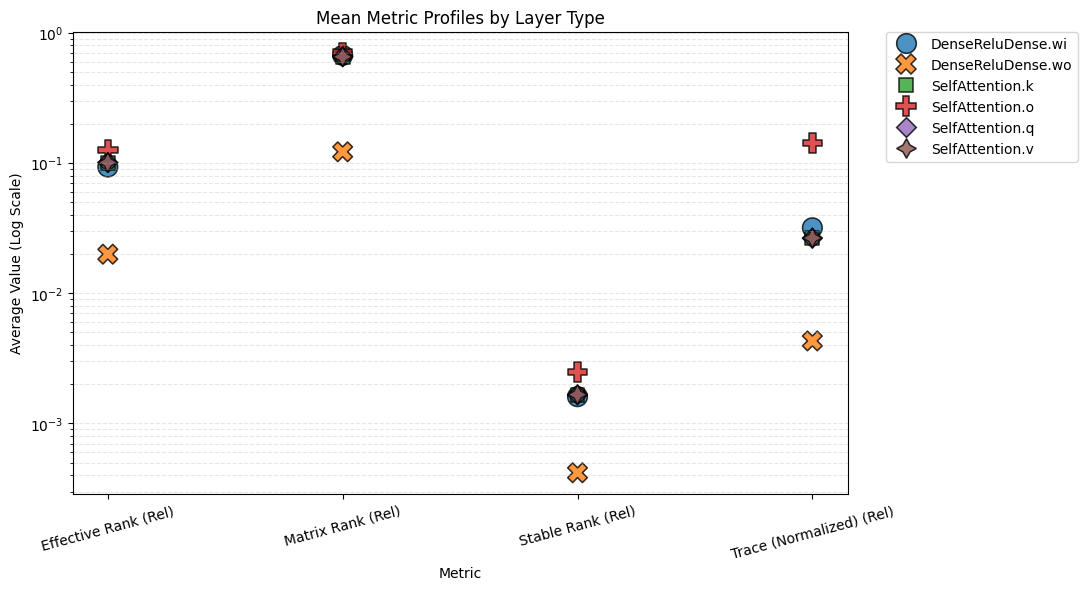

In [ ]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create the bottleneck dimension feature
df['Min_Dim'] = df[['Di', 'Do']].min(axis=1)

# 2. Create new normalized columns with (REL) suffix
rank_cols = ['Stable Rank', 'Matrix Rank', 'Effective Rank', 'Trace (Normalized)', 'Identity Distance']
for col in rank_cols:
    df[f"{col} (Rel)"] = df[col] / df['Min_Dim']


# 1. Define the metrics we want to compare
metrics_to_plot = [
    "Trace (Normalized) (Rel)",  
    "Stable Rank (Rel)", 
    "Matrix Rank (Rel)", 
    "Effective Rank (Rel)"
]

# 2. Melt the dataframe to make it "Long-form"
df_long = df.melt(
    id_vars=["Layer Type"], 
    value_vars=metrics_to_plot, 
    var_name="Metric", 
    value_name="Value"
)

# 3. Calculate averages per Layer Type and Metric
df_avg = df_long.groupby(["Layer Type", "Metric"])["Value"].mean().reset_index()

plt.figure(figsize=(10, 6))

# Plot the averages
sns.scatterplot(
    data=df_avg,
    x="Metric",
    y="Value",
    hue="Layer Type",
    style="Layer Type",
    s=200,
    edgecolor="black",
    alpha=0.8
)

# Move the legend outside to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Since these are (REL) and Normalized, they are likely between 0 and 1
# If Trace is much larger, you might still want a log scale
plt.yscale("log") 
plt.grid(True, which="both", axis='y', ls="--", alpha=0.3)
plt.title("Mean Metric Profiles by Layer Type")
plt.ylabel("Average Value (Log Scale)")
plt.xticks(rotation=15) # Tilt labels if they overlap


Found 6 types: ['SelfAttention.q', 'SelfAttention.k', 'SelfAttention.v', 'SelfAttention.o', 'DenseReluDense.wi', 'DenseReluDense.wo']
Found 12 blocks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


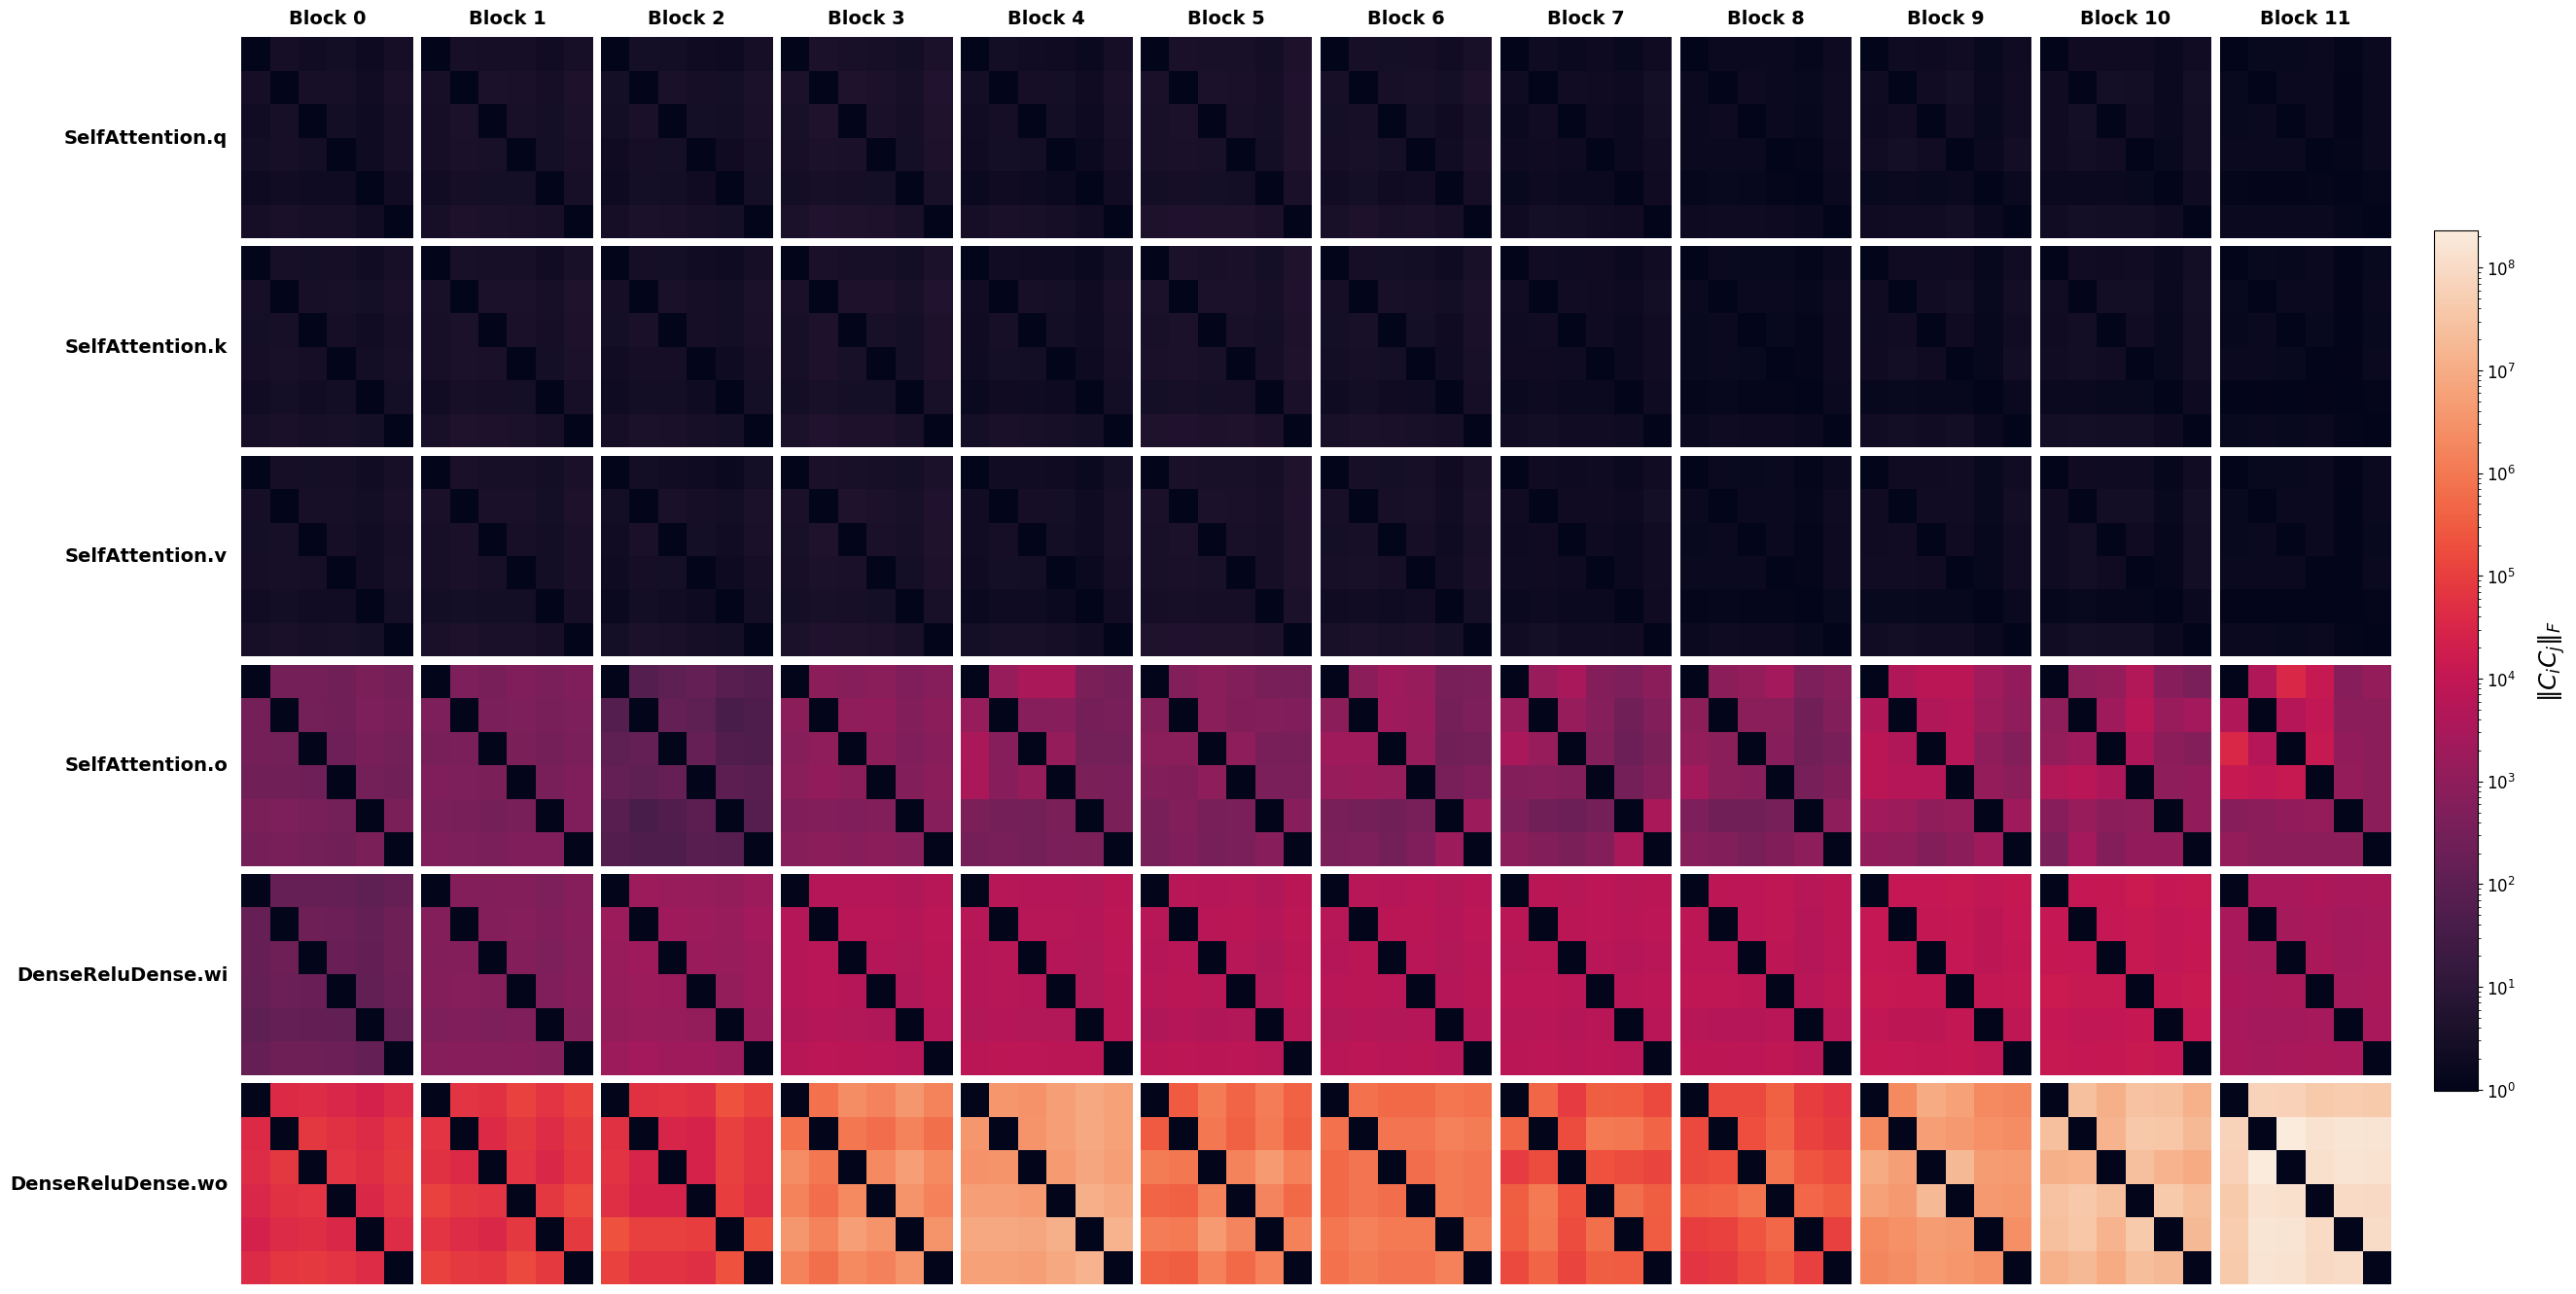

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from matplotlib.colors import LogNorm

# ---------------------------------------------------------
# 1. Parse & Organize
# ---------------------------------------------------------
layer_map = {}
pattern = re.compile(r"block\.(\d+)\.layer\.\d+\.(.+)")

# Optional: Define a logical order for layer types
type_order = {
    "SelfAttention.q": 0, "SelfAttention.k": 1, "SelfAttention.v": 2, "SelfAttention.o": 3,
    "DenseReluDense.wi": 4, "DenseReluDense.wo": 5
}

for i, name in enumerate(layer_names):
    match = pattern.search(name)
    if match:
        block_num = int(match.group(1))
        layer_type = match.group(2)
        layer_map[(block_num, layer_type)] = i

blocks = sorted(list(set(k[0] for k in layer_map.keys())))
unique_types = set(k[1] for k in layer_map.keys())
types = sorted(list(unique_types), key=lambda x: type_order.get(x, 99))

n_rows = len(types)
n_cols = len(blocks)

print(f"Found {n_rows} types: {types}")
print(f"Found {n_cols} blocks: {blocks}")

# ---------------------------------------------------------
# 2. Setup Plot
# ---------------------------------------------------------
fig, axes = plt.subplots(
    n_rows, n_cols, 
    figsize=(n_cols * 2.2, n_rows * 2.2), 
    sharex=True, sharey=True, 
    squeeze=False, 
    constrained_layout=True
)

vmin, vmax = max(sso.min().item(), 1e-6), sso.max().item()
norm = LogNorm(vmin=vmin, vmax=vmax)
font_size = 14

# Variable to store the last mappable for the colorbar
last_mappable = None

# ---------------------------------------------------------
# 3. Plot Grid
# ---------------------------------------------------------
for r, l_type in enumerate(types):
    for c, block in enumerate(blocks):
        ax = axes[r, c]
        idx = layer_map.get((block, l_type))

        if idx is not None:
            data = sso[idx].numpy() if hasattr(sso[idx], "numpy") else sso[idx]
            
            # Draw heatmap
            # Note: We capture the Axes 'ax_out', but the heatmap is inside it
            ax_out = sns.heatmap(
                data, ax=ax, 
                # vmin=vmin, vmax=vmax,
                norm=norm,
                cbar=False, 
                xticklabels=False, yticklabels=False,
                cmap="rocket" 
            )
            
            # Save the mappable from this plot for the global colorbar later
            if last_mappable is None:
                last_mappable = ax_out.collections[0]
        else:
            ax.axis("off")

        if c == 0:
            ax.set_ylabel(l_type, rotation=0, ha='right', va='center', 
                          fontsize=font_size, weight='bold', labelpad=10)

        if r == 0:
            ax.set_title(f"Block {block}", fontsize=font_size, weight='bold', pad=10)

# ---------------------------------------------------------
# 4. Global Colorbar
# ---------------------------------------------------------
# Use the captured mappable (last_mappable) instead of 'im'
if last_mappable:
    cbar = fig.colorbar(last_mappable, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label(r'$\|C_i C_j\|_F$', fontsize=font_size+4, labelpad=15)
    cbar.ax.tick_params(labelsize=12)

plt.savefig("results/sso_grid_grassmann_v2.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Analyze Covariances (III)

In [1]:
import os
import pickle
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

RESULTS_DIR = "results"
MODEL_NAME = "t5-base"
# DATASETS = ["qasc", "wiki_qa"]
DATASETS = ["qasc", "wiki_qa", "quartz", "paws", "winogrande", "wsc"]

layer_name_fn = lambda name: name + ".weight"
dist_fn = lambda x, x_hat: (torch.linalg.norm(x - x_hat, ord="fro") / torch.linalg.norm(x, ord="fro")).item()

rows = []
for d in tqdm(DATASETS):  
    # Load covs and mats
    with open(os.path.join(RESULTS_DIR, f"covs_d{d}_m{MODEL_NAME}.pkl"), "rb") as f:
        covs = pickle.load(f)["covs"]
    with open(os.path.join(RESULTS_DIR, f"mats_d{d}_m{MODEL_NAME}.pkl"), "rb") as f:
        mats = pickle.load(f)

    for k in tqdm(covs.keys(), desc=f"Processing {d}", leave=False, total=len(covs.keys())):
        # Get cov and mat
        km = layer_name_fn(k)
        m = mats[km][1]
        c = torch.from_numpy(covs[k]).to(m.dtype).to(m.device)
        c_hat_eg = m.T @ m # EigenCov estimate
        u, s, vt = torch.linalg.svd(c, full_matrices=False)
        c_hat_egf = vt.T @ vt
        rows.append({"dataset": d, "layer_name": k, "method": "EigenCov", "error": dist_fn(c, c_hat_eg), "shape": c.shape})
        rows.append({"dataset": d, "layer_name": k, "method": "EigenCov (Flat)", "error": dist_fn(c, c_hat_egf), "shape": c.shape})
        rows.append({"dataset": d, "layer_name": k, "method": "Identity", "error": dist_fn(c, torch.eye(c.shape[0], c.shape[1])), "shape": c.shape})

        if m.shape[0] == m.shape[1]:
            c_hat_egr = m @ m.T # EigenCov reversed estimate
            rows.append({"dataset": d, "layer_name": k, "method": "EigenCov (Reversed)", "error": dist_fn(c, c_hat_egr), "shape": c.shape})

100%|██████████| 6/6 [05:22<00:00, 53.68s/it]


In [5]:
import pandas as pd
df = pd.DataFrame(rows)
print(df.to_string(float_format="%.2f"))

         dataset                                              layer_name               method    error         shape
0           qasc     transformer.encoder.block.0.layer.0.SelfAttention.q             EigenCov     0.98    (768, 768)
1           qasc     transformer.encoder.block.0.layer.0.SelfAttention.q      EigenCov (Flat)    14.58    (768, 768)
2           qasc     transformer.encoder.block.0.layer.0.SelfAttention.q             Identity    14.58    (768, 768)
3           qasc     transformer.encoder.block.0.layer.0.SelfAttention.q  EigenCov (Reversed)     1.00    (768, 768)
4           qasc     transformer.encoder.block.0.layer.0.SelfAttention.k             EigenCov     0.97    (768, 768)
5           qasc     transformer.encoder.block.0.layer.0.SelfAttention.k      EigenCov (Flat)    13.72    (768, 768)
6           qasc     transformer.encoder.block.0.layer.0.SelfAttention.k             Identity    13.72    (768, 768)
7           qasc     transformer.encoder.block.0.layer.0.SelfAtt

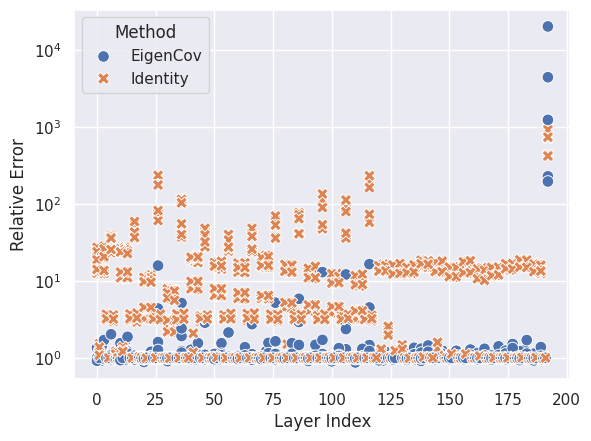

In [8]:
# Map layer names to indices
sns.set_theme()
layer_to_idx = {name: idx for idx, name in enumerate(sorted(df["layer_name"].unique()))}
df["layer_idx"] = df["layer_name"].map(layer_to_idx)
df = df[df["method"] != "EigenCov (Flat)"]
df = df[df["method"] != "EigenCov (Reversed)"]
# df = df[df["layer_name"] != "transformer.lm_head"]

# # only keep first 100 layers
# df = df[df["layer_idx"] < 100]

ax = sns.scatterplot(
    data=df,
    x="layer_idx",
    y="error",
    style="method",
    hue="method",
    s=70
)

plt.xlabel("Layer Index")
plt.ylabel("Relative Error")
# Change legend title to "Method"
if ax.get_legend() is not None:
    legend = ax.get_legend()
    legend.set_title("Method")

# set yscale to log
plt.yscale("log")
# Save figure
plt.savefig(f"results/covs_relerr_m{MODEL_NAME}.pdf", dpi=300, bbox_inches='tight')
plt.show()


### Analyze entanglement matrix

In [26]:
import torch
import pickle
from itertools import product
from tqdm import tqdm

RESULTS_DIR = "results"
DATASETS = [
    "qasc",
    "wiki_qa",
    "quartz",
    "paws",
    # "story_cloze", # error
    "winogrande",
    "wsc",
]
MODEL_NAME = "t5-base"

# Load cov to get layer names
with open(f"{RESULTS_DIR}/covs_d{DATASETS[0]}_m{MODEL_NAME}.pkl", "rb") as f:
    covs = pickle.load(f)["covs"]

layer_names = list(covs.keys())
# layer_names = [l.replace("transformer.encoder.block.", "").replace("layer.", "") for l in layer_names]

# Read deltas
with open(f"{RESULTS_DIR}/entanglements_m{MODEL_NAME}.pkl", "rb") as f:
    entanglements = pickle.load(f)

# Compute alpha*
entanglements.shape
num = torch.einsum("ltit->l", entanglements)
den = torch.einsum("ltij->l", entanglements)
alpha_star = num / den

In [33]:
from typing import Optional
import re
import pandas as pd

_LAYER_TYPE_RE = re.compile(r"(SelfAttention\.(?:q|k|v|o)|DenseReluDense\.(?:wi|wo))$")

def extract_layer_type(name: str) -> Optional[str]:
    m = _LAYER_TYPE_RE.search(name)
    return m.group(1) if m else None

rows = []
for i in range(len(layer_names)):
    rows.append({'layer_idx': i, 'layer_type': extract_layer_type(layer_names[i]), 'alpha_star': alpha_star[i].item()})

df = pd.DataFrame(rows)

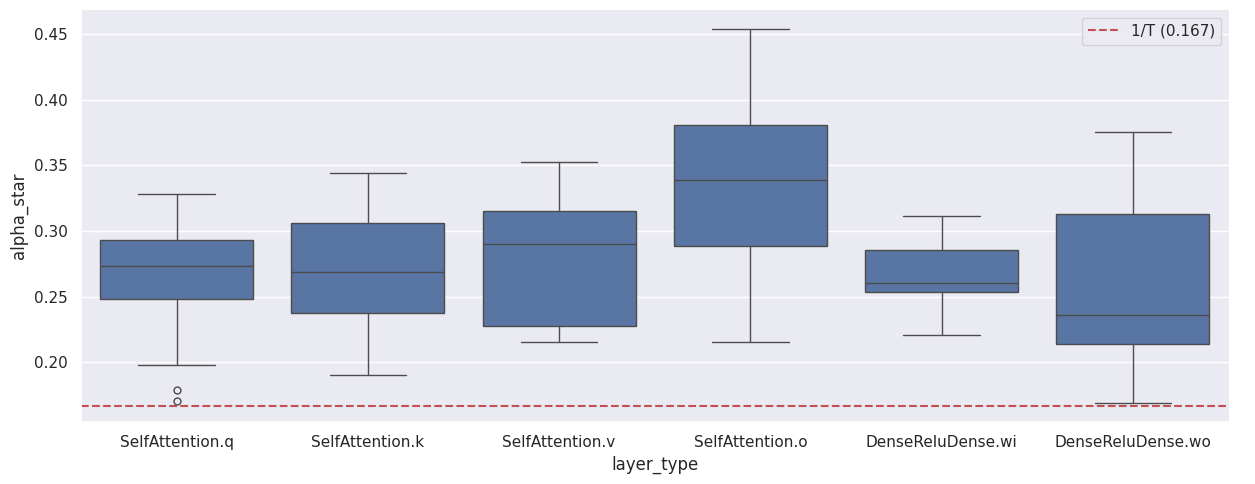

In [ ]:
import seaborn as sns

sns.set_theme()

# kind="box" shows median/quartiles; kind="point" shows mean/error bars
sns.catplot(
    data=df, x='layer_type', y='alpha_star', 
    kind="box", height=5, aspect=2.5
)

# Add horizontal line at y=1/len(DATASETS)
plt.axhline(y=1/len(DATASETS), color='r', linestyle='--', label=f'1/T ({1/len(DATASETS):.3f})')
plt.legend()
plt.show()



In [ ]:
# compute means for each layer type
df.groupby('layer_type')['alpha_star'].mean()

layer_type
DenseReluDense.wi    0.268122
DenseReluDense.wo    0.260045
SelfAttention.k      0.268792
SelfAttention.o      0.335910
SelfAttention.q      0.263365
SelfAttention.v      0.277154
Name: alpha_star, dtype: float64

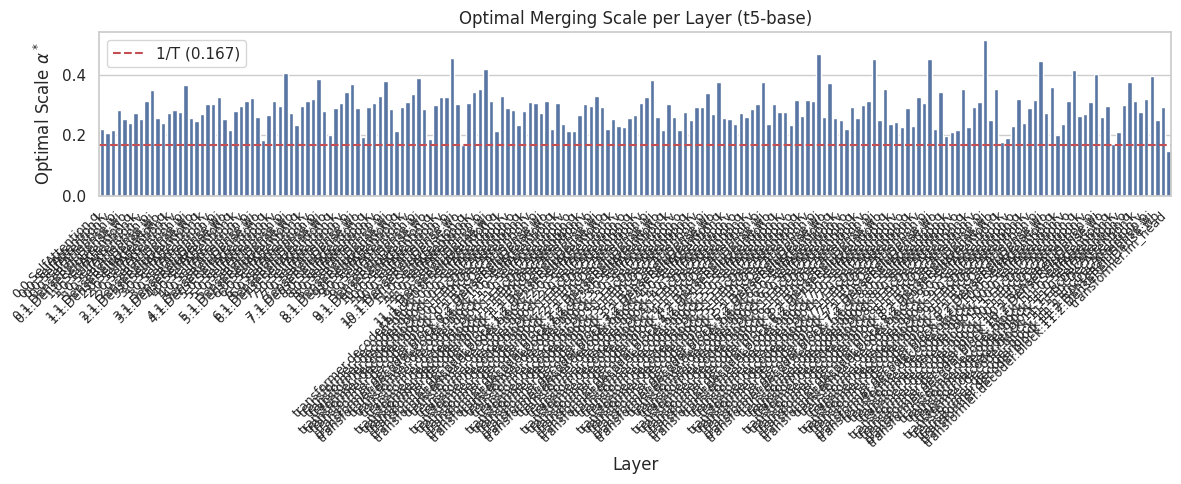

In [24]:
# import seaborn as sns
# # Plot the deltas

# sns.heatmap(deltas[50,2])

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sns.set_theme()

# Setup styling
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))

# Process layer names (shorter names for readability)
# Removes the long prefix and common suffixes
clean_names = [
    l.replace("image_encoder.model.visual.transformer.resblocks.", "")
     .replace(".attn.in_proj_weight", "")
     .replace(".weight", "") 
    for l in layer_names
]

# Create plot
ax = sns.barplot(x=clean_names, y=alpha_star.numpy())

# Fix overlapping ticks
plt.xticks(rotation=45, ha='right', fontsize=9)

# Labels and reference line
plt.ylabel(r"Optimal Scale $\alpha^*$")
plt.xlabel("Layer")
plt.title(f"Optimal Merging Scale per Layer ({MODEL_NAME})")

# Add a reference line for 1/T (the averaging baseline)
plt.axhline(y=1/len(DATASETS), color='r', linestyle='--', label=f'1/T ({1/len(DATASETS):.3f})')
plt.legend()

plt.tight_layout()
plt.show()

### Analyze mats

In [4]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import itertools

MODELS = ["t5-base"]
DATASETS = ["qasc", "quartz", "wiki_qa", "paws", "winogrande", "wsc"]
RESULTS_DIR = "results"

# Compute stats
rows = []
for m, d in tqdm(itertools.product(MODELS, DATASETS), total=len(MODELS) * len(DATASETS), desc="Processing model-dataset pairs"):
    with open(f"{RESULTS_DIR}/mats_d{d}_m{m}.pkl", "rb") as f:
        mats = pickle.load(f)

    for k in tqdm(mats.keys(), total=len(mats.keys()), desc=f"Processing {d}", leave=False):

        # If not a mat, skip
        if not len(mats[k][0].shape) == 2:
            continue

        # v: (w0, delta)
        _, delta = mats[k][0], mats[k][1]
        _, s, _ = torch.svd(delta)
        stable_rank = compute_stable_rank(s)
        matrix_rank = compute_matrix_rank(delta)
        effective_rank = compute_effective_rank(s)
        rows.append({
            'model': m,
            'dataset': d,
            'do': delta.shape[0],
            'di': delta.shape[1],
            'layer_name': k,
            'layer_type': extract_layer_type(k),
            'rank_stable': stable_rank,
            'rank_matrix': matrix_rank,
            'rank_effective': effective_rank
        })


Processing model-dataset pairs: 100%|██████████| 6/6 [03:47<00:00, 37.98s/it]


In [6]:
# Print df (Sort by layer type)
df = pd.DataFrame(rows)
print(df.to_string())

        model     dataset     do    di                                                                        layer_name         layer_type  rank_stable  rank_matrix  rank_effective
0     t5-base        qasc  32128   768                                                         transformer.shared.weight               None     1.427712          768      562.090393
1     t5-base        qasc  32128   768                                           transformer.encoder.embed_tokens.weight               None     1.427712          768      562.090393
2     t5-base        qasc    768   768                        transformer.encoder.block.0.layer.0.SelfAttention.q.weight    SelfAttention.q     4.951542          766      416.612488
3     t5-base        qasc    768   768                        transformer.encoder.block.0.layer.0.SelfAttention.k.weight    SelfAttention.k     4.992003          766      407.174774
4     t5-base        qasc    768   768                        transformer.encoder.block.0.

In [8]:
# Save to csv
df.to_csv(f"{RESULTS_DIR}/srank_t5.csv", index=False)

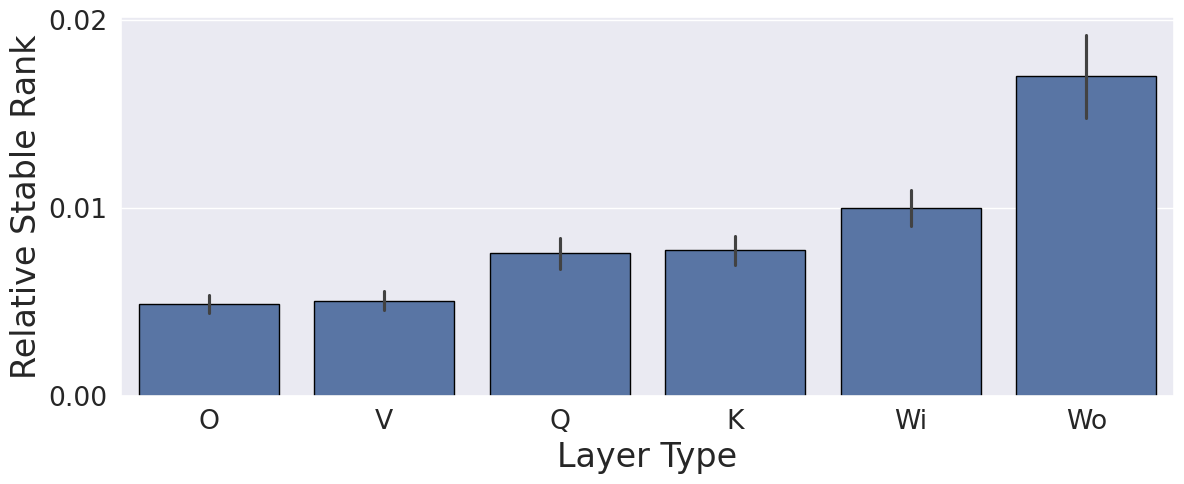

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ===============================
# Global font size (edit once)
# ===============================
BASE_FONTSIZE = 24

sns.set_theme(style="darkgrid")

df = pd.read_csv(f"{RESULTS_DIR}/srank_t5.csv")
MODEL_NAME = "t5-base"

# --- Compute normalized stable rank ---
df['dim_min'] = df[['di', 'do']].min(axis=1)
df['rank_stable_rel'] = df['rank_stable'] / df['dim_min']

# --- Rename layer_type ---
rename_map = {
    "SelfAttention.q": "Q",
    "SelfAttention.k": "K",
    "SelfAttention.v": "V",
    "SelfAttention.o": "O",
    "DenseReluDense.wi": "Wi",
    "DenseReluDense.wo": "Wo",
}
df["layer_type"] = df["layer_type"].replace(rename_map)

canonical_order = ["Q", "K", "V", "O", "Wi", "Wo"]
sorted_order = df.groupby('layer_type')['rank_stable_rel'].mean().sort_values().index

plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=df,
    x="layer_type",
    y="rank_stable_rel",
    # hue="model",
    order=sorted_order,
    edgecolor="black"
)

# ---- Axis labels ----
ax.set_ylabel("Relative Stable Rank", fontsize=BASE_FONTSIZE)
ax.set_xlabel("Layer Type", fontsize=BASE_FONTSIZE)

# ---- Reduce y-ticks ----
ymin, ymax = ax.get_ylim()
ax.set_yticks([0, 0.01, 0.02])

# ---- Set xtick and ytick font sizes ----
ax.tick_params(axis='x', labelsize=BASE_FONTSIZE * 0.8)
ax.tick_params(axis='y', labelsize=BASE_FONTSIZE * 0.8)

# ---- Axis spine thickness ----
for spine in ax.spines.values():
    spine.set_linewidth(1.2)

# ---- Legend ----
handles, labels = ax.get_legend_handles_labels()
# ax.legend(
#     handles,
#     labels,
#     title="Model",
#     fontsize=BASE_FONTSIZE * 0.85,
#     title_fontsize=BASE_FONTSIZE * 0.9
# )

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/srank_m{MODEL_NAME}.pdf", dpi=300, bbox_inches='tight')


           layer_type           metric      value
0   DenseReluDense.wi      rank_stable   7.667564
1   DenseReluDense.wi  rank_stable_rel   0.009984
2   DenseReluDense.wo      rank_stable  13.065307
3   DenseReluDense.wo  rank_stable_rel   0.017012
4     SelfAttention.k      rank_stable   5.961688
5     SelfAttention.k  rank_stable_rel   0.007763
6     SelfAttention.o      rank_stable   3.757240
7     SelfAttention.o  rank_stable_rel   0.004892
8     SelfAttention.q      rank_stable   5.844159
9     SelfAttention.q  rank_stable_rel   0.007610
10    SelfAttention.v      rank_stable   3.892466
11    SelfAttention.v  rank_stable_rel   0.005068


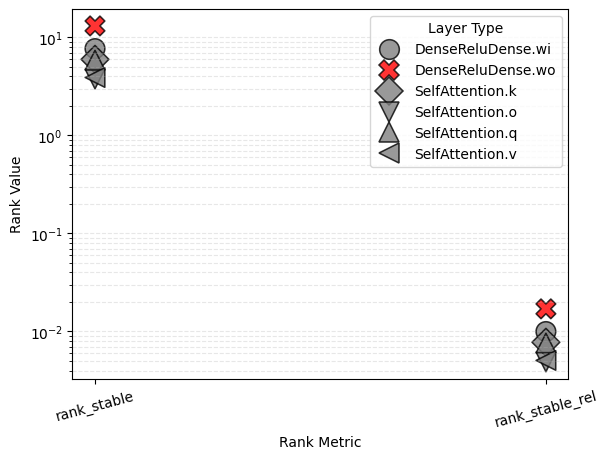

In [5]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0. Create the dataframe
df = pd.DataFrame(rows)

# 1. Create the bottleneck dimension feature
df['dim_min'] = df[['di', 'do']].min(axis=1)

# 2. Create new normalized columns with (Rel) suffix
rank_cols = ['rank_stable', 'rank_matrix', 'rank_effective']
for col in rank_cols:
    df[f"{col}_rel"] = df[col] / df['dim_min']



# 1. Define the metrics we want to compare
metrics_to_plot = [
    # Absolute
    "rank_stable",  
    # "rank_matrix", 
    # "rank_effective",
    # Relative
    "rank_stable_rel",  
    # "rank_matrix_rel", 
    # "rank_effective_rel",
]

# 2. Melt the dataframe to make it "Long-form"
df_long = df.melt(
    id_vars=["layer_type"], 
    value_vars=metrics_to_plot, 
    var_name="metric", 
    value_name="value"
)

# 3. Calculate averages per Layer Type and Metric
df_avg = df_long.groupby(["layer_type", "metric"])["value"].mean().reset_index()


# Set markers and colors
unique_layers = df_avg['layer_type'].unique()
other_markers = ['o', 's', 'D', 'v', '^', '<', '>', 'p']
marker_map = {
    "DenseReluDense.wo": "X",
    **{l: other_markers[i] for i, l in enumerate(unique_layers) if l != "DenseReluDense.wo"}
}
color_map = {
    "DenseReluDense.wo": "red",
    **{l: "gray" for l in unique_layers if l != "DenseReluDense.wo"}
}

# Plot the averages
sns.scatterplot(
    data=df_avg,
    x="metric",
    y="value",
    hue="layer_type",
    style="layer_type",
    s=200,
    edgecolor="black",
    alpha=0.8,
    markers=marker_map,
    palette=color_map
)

# Move the legend outside to the right
# leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
leg = plt.legend()
leg.set_title("Layer Type")

plt.yscale("log") 
plt.grid(True, which="both", axis='y', ls="--", alpha=0.3)
plt.xlabel("Rank Metric")
plt.ylabel("Rank Value")
plt.xticks(rotation=15) # Tilt labels if they overlap
print(df_avg)
plt.savefig(f"results/sranks_m{MODEL_NAME}.pdf", dpi=300, bbox_inches='tight')


<Axes: xlabel='layer_type', ylabel='rank_stable_rel'>

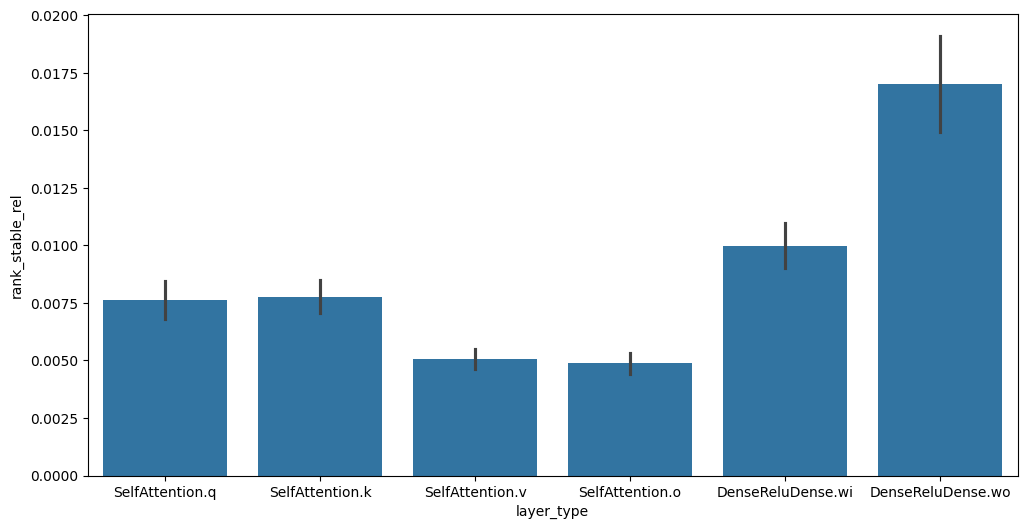

In [9]:
# plt.yscale("log") 
# plt.grid(True, which="both", axis='y', ls="--", alpha=0.3)
# plt.xlabel("Rank Metric")
# plt.ylabel("Rank Value")
# plt.xticks(rotation=15) # Tilt labels if they overlap
# print(df_avg)
# plt.savefig(f"results/sranks_m{MODEL_NAME}.pdf", dpi=300, bbox_inches='tight')

# Another plot that just shows the rank_stable for each layer type

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="layer_type", y="rank_stable_rel", data=df)